<h4>Features 08-08-2024</h4>

In [1]:
from pathlib import Path
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import *
from tqdm import tqdm


import polars as pl
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


ROOT_DIR = Path(os.getcwd()).parent.parent

In [2]:
@dataclass
class PumpEvent:
    pump_id: int
    ticker: str
    time: str
    exchange: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Pump event: {self.ticker} - {str(self.time)} on {self.exchange}"

In [3]:
# data is organized by days
pump = PumpEvent(
    pump_id=1, ticker="VIABTC", time="2019-02-03 15:04:00", exchange="binance"
)

def load_data(pump: PumpEvent, lookback_delta: timedelta) -> pd.DataFrame:

    end: pd.Timestamp = pump.time.round("1h") - timedelta(hours=1)
    start: pd.Timestamp = end - lookback_delta
    
    date_range: List[pd.Timestamp] = pd.date_range(
        start=start,
        end=end, freq="D",
        inclusive="both"
    ).tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in tqdm(date_range):
        try:
            file_name: str = f"{pump.ticker}-trades-{date.date()}.parquet"
            df_date: pd.DataFrame = pd.read_parquet(
                os.path.join(ROOT_DIR, f"data/trades_parquet/{pump.exchange}/{pump.ticker}", file_name)
            )
        except FileNotFoundError:
            continue
            
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")
    df = df[(df["time"] >= start) & (df["time"] <= end)].reset_index(drop=True)

    return df

In [4]:
df = load_data(pump=pump, lookback_delta=timedelta(days=30))
df["quote"] = df["qty"] * df["price"]

100%|██████████| 31/31 [00:00<00:00, 433.09it/s]


In [5]:
df["qty_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["qty"]
df["quote_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["quote"]

# Aggregate by time into rush orders
df_trades: pd.DataFrame = df.groupby("time").agg(
    price_first=("price", "first"),
    price_last=("price", "last"),
    price_max=("price", "max"),
    price_min=("price", "min"),
    qty_sign=("qty_sign", "sum"),
    qty_abs=("qty", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_abs=("quote", "sum"),
)

df_trades["is_long"] = df_trades["qty_sign"] >= 0 # is buyer
df_trades["quote_long"] = df_trades["quote_abs"] * df_trades["is_long"] # quote volume for longs
df_trades["quote_short"] = df_trades["quote_abs"] * ~df_trades["is_long"] # quote volume for shorts
 
df_trades = df_trades.reset_index()
df_trades.head(2)

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,is_long,quote_long,quote_short
0,2019-01-04 14:11:13.875,0.000082,0.000082,0.000082,0.000082,719.12,719.12,0.058994,0.058994,True,0.058994,0.0
1,2019-01-04 14:11:13.876,0.000082,0.000082,0.000082,0.000082,169.61,169.61,0.013925,0.013925,True,0.013925,0.0


<h4>Slippages</h4>

$$
\text{Slippage Loss} = \underbrace{\sum_{i=1}^{N}{\text{qty\_sign}_i} \cdot P_i}_{\text{Quote actually spent}} \: - \underbrace{\sum_{i=1}^N{\text{qty\_sign}_i} \cdot P_0}_{\substack{\text{Quote could have been spent} \\ \text{if filled at best price}}}
$$

This formula calculates the slippage loss as the difference between quote we actually spent and quote amount we would have paid if we were able to execute at the best bid or ask price (depending on the side of the trade)

In [6]:
# calculate slippages
df_trades["quote_slippage_abs"] = np.abs(
    df_trades["quote_abs"] - df_trades["qty_abs"] * df_trades["price_first"]
)
df_trades["quote_slippage_sign"] = df_trades["quote_slippage_abs"] * np.sign(df_trades["qty_sign"])
df_trades["quote_slippage_long"] = df_trades["quote_slippage_abs"] * df_trades["is_long"]

<h4>Liquidity measure</h4>

<h4>OLS regression of quote_slippage_abs on quote_abs</h4>

In [7]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant


X = df_trades["quote_abs"]
X = add_constant(X)

Y = df_trades["quote_slippage_abs"]

model = OLS(exog=X, endog=Y).fit()

a, b = model.params

$\mathbb{E}(Y | X)$

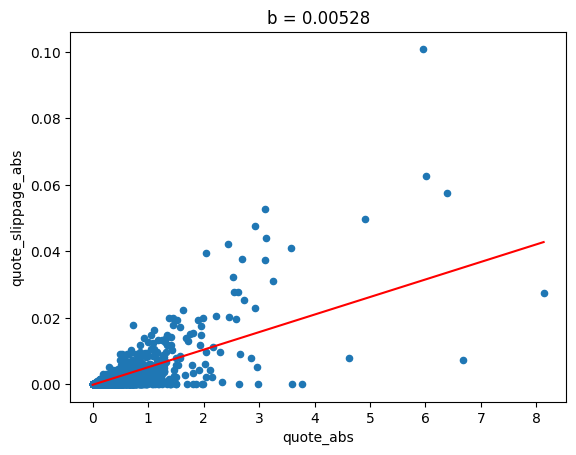

In [8]:
X = np.linspace(0, df_trades["quote_abs"].max(), 1000)
Y = a + b * X

df_trades.plot.scatter(y="quote_slippage_abs", x="quote_abs")

plt.plot(X, Y, color="red")
plt.title(f"b = {b:.5f}")
plt.show()

$\mathbb{E}(Y | X, Y > 0)$

In [9]:
df_slip = df_trades[df_trades["quote_slippage_abs"] > 0].copy()

X = df_slip["quote_abs"]
X = add_constant(X)

Y = df_slip["quote_slippage_abs"]

model = OLS(exog=X, endog=Y).fit()

a, b = model.params

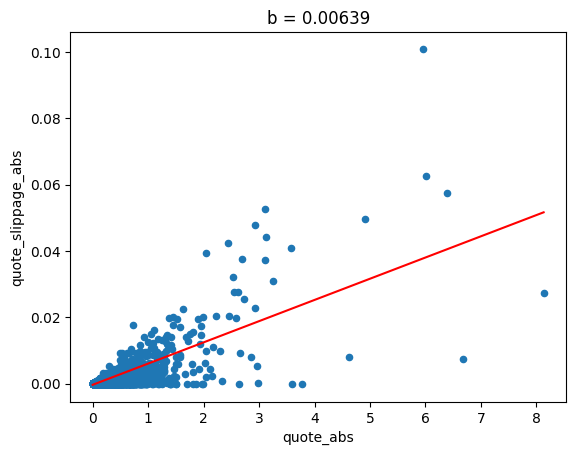

In [10]:
X = np.linspace(0, df_slip["quote_abs"].max(), 1000)
Y = a + b * X

df_trades.plot.scatter(y="quote_slippage_abs", x="quote_abs")

plt.plot(X, Y, color="red")
plt.title(f"b = {b:.5f}")
plt.show()

In [11]:
def calculate_linear_liquidity_index(df_trades: pd.DataFrame) -> float:
    X = df_trades["quote_abs"]
    X = add_constant(X)

    Y = df_trades["quote_slippage_abs"]

    model = OLS(exog=X, endog=Y).fit()
    a, b = model.params

    return b

In [12]:
time_ub: pd.Timestamp = pump.time.round("1h") - timedelta(hours=1)

In [13]:
hour_offsets: List[int] = [1, 6, 24, 48, 72, 7*24, 14*24]

liquidity_features: Dict[str, float] = {}

for offset in hour_offsets:
    df_window: pd.DataFrame = df_slip[df_slip["time"] >= time_ub - timedelta(hours=offset)].copy()
    liquidity_features[f"linear_liquidity_slope_{offset}h"] = calculate_linear_liquidity_index(df_trades=df_window)

liquidity_features

{'linear_liquidity_slope_1h': 0.0004585759115306275,
 'linear_liquidity_slope_6h': 0.0005576804255115289,
 'linear_liquidity_slope_24h': 0.012011708043641413,
 'linear_liquidity_slope_48h': 0.010335141690241948,
 'linear_liquidity_slope_72h': 0.009188689004716488,
 'linear_liquidity_slope_168h': 0.006487697731341743,
 'linear_liquidity_slope_336h': 0.007198590695728365}

<h4>Order quote size affect on probability of slippage</h4>

In [14]:
def regress_proba_slippage_on_quote_abs(df_trades: pd.DataFrame) -> Tuple[float, float, pd.DataFrame]:
    """Compute the effect of quote_abs size on probability that the final trade will be executed with some slippage"""
    bins = np.arange(0, df_trades["quote_abs"].max(), 0.001)
    
    df_trades["quote_abs_bin"] = pd.cut(df_trades["quote_abs"], bins=bins)
    df_trades["quote_abs_bin"] = df_trades["quote_abs_bin"].apply(lambda x: x.right)

    df_trades["has_slippage"] = df_trades["quote_slippage_abs"] > 0 

    # Compute probas for all bins
    probas: List[dict] = []

    for bin, df_bin in df_trades.groupby("quote_abs_bin", observed=True):

        if df_bin.shape[0] >= 10:
            probas.append({
                "quote_bin": bin,
                "slippage_proba": df_bin["has_slippage"].mean() # compute the share of trades with any slippage within this bin
            })

    df_probas = pd.DataFrame(probas)

    # Regress
    X = df_probas["quote_bin"]
    X = add_constant(X)
    Y = df_probas["slippage_proba"]

    model = OLS(endog=Y, exog=X).fit()
    a, b = model.params

    return a, b, df_probas

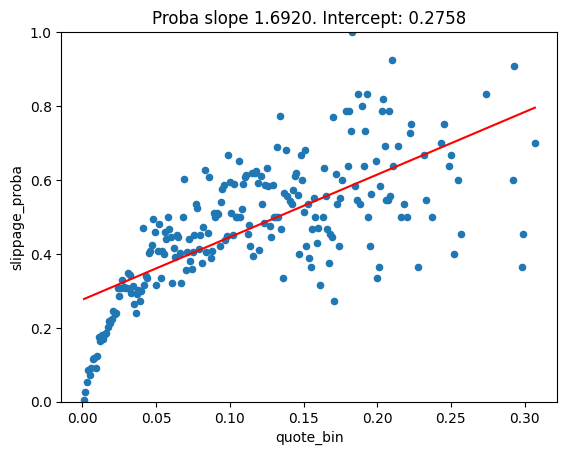

In [15]:
# fit OLS
a, b, df_probas = regress_proba_slippage_on_quote_abs(df_trades=df_trades)

X = df_probas["quote_bin"]
Y = a + b*X

df_probas.plot.scatter(x="quote_bin", y="slippage_proba")
plt.plot(X, Y, color="red")

plt.title(f"Proba slope {b:.4f}. Intercept: {a:.4f}")
plt.ylim(0, 1)

plt.show()

In [16]:
offsets: List[int] = [1, 3, 7, 14, 30]

liquidity_proba_features: Dict[str, float] = {}

for offset in offsets:
    df_window: pd.DataFrame = df_trades[df_trades["time"] >= time_ub - timedelta(days=offset)].copy()
    a, b, _ = regress_proba_slippage_on_quote_abs(df_trades=df_window)

    liquidity_proba_features[f"has_slippage_slope_{offset}d"] = b
    liquidity_proba_features[f"has_slippage_intercept_{offset}d"] = a

liquidity_proba_features

{'has_slippage_slope_1d': 6.302239889245846,
 'has_slippage_intercept_1d': 0.0331051925585417,
 'has_slippage_slope_3d': 9.433536964692872,
 'has_slippage_intercept_3d': 0.040406173036374914,
 'has_slippage_slope_7d': 6.586905628212643,
 'has_slippage_intercept_7d': 0.10241656107813758,
 'has_slippage_slope_14d': 3.2325757689868393,
 'has_slippage_intercept_14d': 0.19662171036356613,
 'has_slippage_slope_30d': 1.6919666866153844,
 'has_slippage_intercept_30d': 0.2757759198249284}

<h4>Log returns features</h4>

In [17]:
df_hourly_candles: pd.DataFrame = (
    df_trades
    .resample(on="time", rule="1h", closed="left")
    .agg(
        open=("price_first", "first"),
        close=("price_last", "last"),
        low=("price_min", "min"),
        high=("price_max", "max"),
        volume_qty_abs=("qty_abs", "sum"), # absolute volume in base asset
        volume_quote_abs=("quote_abs", "sum"), # absolute volume in quote asset
        volume_quote_abs_long=("quote_long", "sum"),
        num_trades=("is_long", "count"), 
        num_trades_long=("is_long", "sum"), 
        quote_slippage_abs=("quote_slippage_abs", "sum"), # slippage loss incurred by both buy and sell sides
        quote_slippage_abs_long=("quote_slippage_long", "sum") # quote slippage incurred by longs
    )
).reset_index()

df_hourly_candles["log_return"] = np.log(
    df_hourly_candles["close"] / df_hourly_candles["close"].shift(1)
)

In [24]:
# long run mean and std of volumes in base and quote
df_hourly_lr: pd.DataFrame = df_hourly_candles[
    df_hourly_candles["volume_quote_abs"] <= df_hourly_candles["volume_quote_abs"].quantile(.99)
].copy()

In [25]:
hour_offsets: List[int] = [1, 6, 24, 48, 72, 7*24, 14*24]

hourly_features: Dict[str, float] = {}

for offset in hour_offsets:
    df_window: pd.DataFrame = df_hourly_candles[df_hourly_candles["time"] >= time_ub - timedelta(hours=offset)].copy()
    
    hourly_features[f"overall_return_{offset}h"] = (df_window["log_return"] + 1).prod() # overall return if held for the whole window up to the last hour

    # Scaled volumes in base and quote assets
    hourly_features[f"volume_quote_abs_zscore_{offset}h_30d"] = (
        (df_window["volume_quote_abs"].mean() - df_hourly_lr["volume_quote_abs"].mean()) / df_hourly_lr["volume_quote_abs"].std()
    )

    # hourly_features[f"num_trades_long_share_{offset}h"] = df_window["num_trades_long"].sum() / df_window["num_trades"].sum()
    hourly_features[f"volume_quote_long_share_{offset}h"] = df_window["volume_quote_abs_long"].sum() / df_window["volume_quote_abs"].sum()

    if offset == 1:
        continue
    # Hourly log returns volatility scaled by long run volatility
    hourly_features[f"log_return_std_{offset}h_30d"] = np.log(df_window["log_return"].std() / df_hourly_lr["log_return"].std())
    # hourly log returns mean scaled by long run std -> z-score
    hourly_features[f"log_return_zscore_{offset}h_30d"] = df_window["log_return"].mean() / df_hourly_lr["log_return"].std() 

<h4>Slippage features</h4>

In [26]:
slippage_features: Dict[str, float] = {}

df_hourly_candles_120h: pd.DataFrame = df_hourly_candles[
    df_hourly_candles["time"] >= time_ub - timedelta(hours=120)
].copy()

hour_offsets: List[int] = [1, 6, 24, 48, 72]

for offset in hour_offsets:
    df_window: pd.DataFrame = df_hourly_candles[df_hourly_candles["time"] >= time_ub - timedelta(hours=offset)].copy()
    # Share of overall slippages of this time window in 120hours
    slippage_features[f"quote_slippage_abs_share_{offset}h_120h"] = (
        df_window["quote_slippage_abs"].sum() / df_hourly_candles_120h["quote_slippage_abs"].sum()
    )

len(slippage_features)

5

<h4>Imbalance features</h4>

In [27]:
imbalance_features: Dict[str, float] = {}

for offset in hour_offsets:
    df_window: pd.DataFrame = df_trades[df_trades["time"] >= time_ub - timedelta(hours=offset)].copy()
    # Volume imbalance ratio to see if there is more buying pressure
    imbalance_features[f"quote_imbalance_ratio_{offset}h"] = df_window["quote_sign"].sum() / df_window["quote_abs"].sum()
    # Imbalance ratio in slippages to see if there is skew towards long slippages
    imbalance_features[f"quote_slippage_imbalance_ratio_{offset}h"] = df_window["quote_slippage_sign"].sum() / df_window["quote_slippage_abs"].sum()

len(imbalance_features)

10

<h4>EVT features</h4>

In [45]:
def estimate_alpha_mle(data: pd.Series) -> float:
    """Hills estimator of powerlaw alpha"""
    n = len(data)
    xmin = min(data)
    alpha = 1 + n / np.sum(np.log(data / xmin))

    return alpha

evt_features: Dict[str, float] = {}

for offset in hour_offsets:
    df_window: pd.DataFrame = df_trades[df_trades["time"] >= time_ub - timedelta(hours=offset)].copy()


    evt_features[f"quote_abs_powerlaw_alpha_{offset}h"] = estimate_alpha_mle(
        data=df_window["quote_abs"]
    )

evt_features

{'quote_abs_powerlaw_alpha_1h': 1.4231224673455731,
 'quote_abs_powerlaw_alpha_6h': 1.4036145282889363,
 'quote_abs_powerlaw_alpha_24h': 1.1356229275469014,
 'quote_abs_powerlaw_alpha_48h': 1.1191055436580655,
 'quote_abs_powerlaw_alpha_72h': 1.119763813744268}